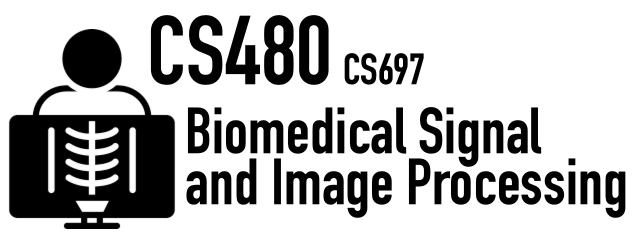
#Assignment 2

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# we will be using the EEG/MEG analysis library MNE
# documentation is available here: https://mne.tools/stable/index.html
!pip install -U mne

In [3]:
import mne # let's import MNE

# .. and the sample dataset
from mne.datasets import sample
from mne.channels import combine_channels
from mne.evoked import combine_evoked

# These data were acquired with the Neuromag Vectorview system at 
# MGH/HMS/MIT Athinoula A. Martinos Center Biomedical Imaging. 
# EEG data from an electrode cap was acquired simultaneously with the MEG. 

### EXPERIMENT DESCRIPTION ###
# In this experiment, checkerboard patterns were presented to the subject into
# the left and right visual field, interspersed by tones to the left or right ear.
# The interval between the stimuli was 750 ms. Occasionally a smiley face was 
# presented at the center of the visual field. The subject was asked to press a 
# key with the right index finger as soon as possible after the appearance of the face.

In [4]:
# and let's load it!
data_path = sample.data_path()
raw = mne.io.read_raw_fif(data_path + '/MEG/sample/sample_audvis_raw.fif')

Opening raw data file C:\Users\thucd\mne_data\MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


**Task 1:** How many EEG channels were used when acquiring the data? [15 Points]


In [ ]:
# Hint: You can use raw.info or raw.ch_names to figure this out.

In [5]:
EEG_count = 0
for ch_name in raw.ch_names:
    if 'EEG' in ch_name:
        EEG_count += 1

In [6]:
n_channel = len(raw.ch_names)
print(n_channel)

376


In [7]:
print(f"There were {EEG_count} EEG channels among {len(raw.ch_names)} channels used when acquiring the data.")

There were 60 EEG channels among 376 channels used when acquiring the data.


* There are in total of 60 collection of channels

**Task 2:** Let's look at some channels! [20 Points]

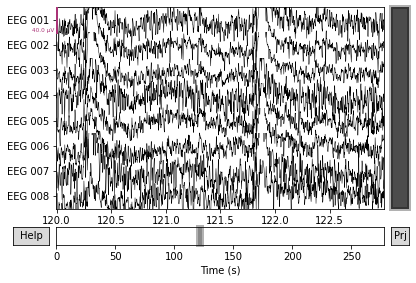

In [8]:
# the code below plots EEG channels 1-8 for 3 seconds after 2 minutes
chs = ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
ecg1to8 = raw.plot(order=chan_idxs, start=120, duration=3)

In [9]:
# plot EEG channels 50-60 for 1 second after 200 seconds.

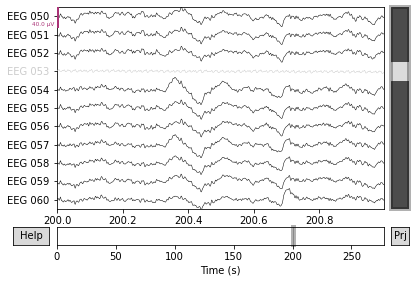

In [9]:
# List comprehension and string concatenation to make the list of channel names
chs = ['EEG 0' + str(i) for i in range(50,61)]
# Get the channel indices
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
# Plot
ecg50to60 = raw.plot(order=chan_idxs, start=200, duration=1)

**Task 3:** How long between event and brain activity? [30 Points]

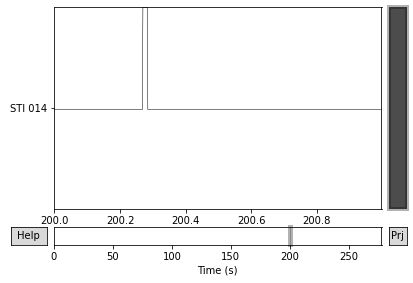

In [10]:
# the following code plots the stimulus channel for the same time
channel_indices = [raw.ch_names.index('STI 014')]
stim = raw.plot(order=channel_indices, start=200, duration=1)

In [ ]:
# combine the last two plots into one.
# the plot should show EEG channels 50-60 and the stimulus channel together.

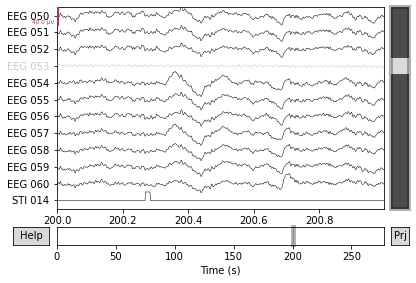

In [11]:
# filter by EEG name and then filter again by number 50-60
filtered = filter(lambda x: x[:3] == 'EEG',raw.ch_names)
filtered = filter(lambda x: 50 <= int(x[-3:]) <= 60,filtered)
chs = list(filtered)
# Added this check here to avoid re-appending each time I re-run this cell
if 'STI 014' not in chs:
        chs.append('STI 014')
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
ecg1to8 = raw.plot(order=chan_idxs, start=200, duration=1)


In [ ]:
# Estimate the time between stimulus and brain activity.

In [12]:
# filter by EEG name and then filter again by number 50-60
filtered = filter(lambda x: x[:3] == 'EEG',raw.ch_names)
filtered = filter(lambda x: 50 <= int(x[-3:]) <= 60,filtered)
chs = list(filtered)

# let's copy to be data safe and cause no weird errors
# we must load first all the data to allow filtering by frequency
# I bandpassed the data with a lowcut to get rid of the baseline shift and a 
# high cut to get rid of the noise
# now I can trust that finding the max corresponds to the first spike
bandpassed_raw = raw.copy()
bandpassed_raw.load_data()
bandpassed_raw = bandpassed_raw.filter(l_freq=2,h_freq=20)

# I took the data and put into into numpy form
bandpassed_data = bandpassed_raw.get_data(chs)
# The data is given back flattened so I arranged it into rows for each channel
bandpassed_data = np.reshape(bandpassed_data, (len(chs), len(raw.times)) )
# I took the mean across the channels axis to get the mean filtered signal
mean_bandpassed_data = np.mean(bandpassed_data, axis=0)

# I got the first sample index of the 200 to 201 duration sample range 
# and I also got its last sample index
index_range = np.argwhere((raw.times >= 200) & (raw.times <= 201 ))
firstRangeIndex = index_range[0][0]
lastRangeIndex = index_range[-1][0]

print("ANSWERS:")
# The index of the peak is the starting sample index of the duration range plus
 # the index of the max value within the duration range
peak_index = firstRangeIndex + mean_bandpassed_data[firstRangeIndex:lastRangeIndex+1].argmax()
raw.times[peak_index]
print("The time in seconds of the first spike after the stimulus is: {}".format(raw.times[peak_index]))

# Now all we have to do is take the argmax value of the stimulus channel to find its starting index in a similar way to the mean filtered EEG data
stimulus_data = raw.get_data('STI 014')
stim_data_inRange = stimulus_data[0,firstRangeIndex:lastRangeIndex+1]
stimulus_start_index = firstRangeIndex + stim_data_inRange.argmax()
print("The time in seconds of the beginning of the stimulus is: {}".format(raw.times[stimulus_start_index]))
print()

# let's subtract the first stimulus presentation time from the first spike in brain activity time to get the duration between stimulus to response
print("Hence the estimated time in seconds between stimulus and brain activity is: {}".format(raw.times[peak_index]-raw.times[stimulus_start_index]))
print("Also the time in milliseconds is {}".format((raw.times[peak_index]-raw.times[stimulus_start_index])*1000))

Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 993 samples (1.653 sec)

ANSWERS:
The time in seconds of the first spike after the stimulus is: 200.36296455577963
The time in seconds of the beginning of the stimulus is: 200.26972678963904

Hence the estimated time in seconds between stimulus and brain activity is: 0.09323776614058943
Also the time in milliseconds is 93.23776614058943


** Estimation **
* As displayed on the graph of EEG 50-60, the highest peak is shown in the EEG-054, the number is roughly 200.36 secs after 200 seconds.
* About 200.25 secs after 200 secs, the number of seconds is represented as peaking for stimilus 014 channel.
* Therefore, the estimation between stimulus and brain activity are 200.36 - 200.25 = 0.11 secs


**Task 4:** Localize different brain waves for different stimuli! [35 Points]

In [13]:
# the following code groups all stimuli together
# and allows the visualization of average brain activity per stimuli.
events = mne.find_events(raw, stim_channel='STI 014')
event_dict = {'auditory/left': 1, 
              'auditory/right': 2, 
              'visual/left': 3,
              'visual/right': 4,
              'face': 5, 
              'button': 32}

picks = mne.pick_types(raw.info, eeg=True)

epochs = mne.Epochs(raw, events, event_id=event_dict, picks=picks,
                    preload=True)

320 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
Not setting metadata
320 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
3 projection items activated
Loading data for 320 events and 421 original time points ...
0 bad epochs dropped


    Using multitaper spectrum estimation with 7 DPSS windows


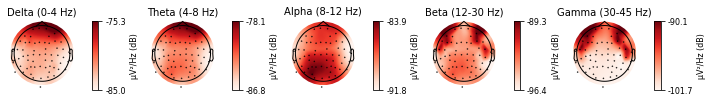

In [14]:
# here we see the average localized brain activity for the right visual stimuli
visual_activity = epochs['visual/right'].plot_psd_topomap()

    Using multitaper spectrum estimation with 7 DPSS windows


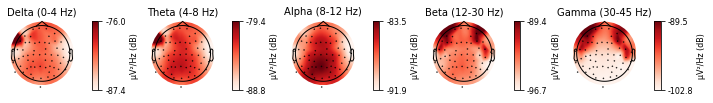

In [15]:
# here we see the average localized brain activity for the shown 'face'
face_activity = epochs['face'].plot_psd_topomap()

In [ ]:
# TODO Please visualize the average brain activity when the subject pushes the button

    Using multitaper spectrum estimation with 7 DPSS windows


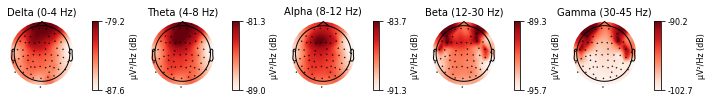

In [16]:
button_activity = epochs['button'].plot_psd_topomap()

In [ ]:
# Which difference do you see between the visual/right, the face, and the button event?
# Which brain region seems active during the button event?
# visual/right and face seem more similar to the button event.

* The most common and equivalent brain scanning to the three activities, including visual/right, face, and pressing button, is having Beta and Gamma stimuli pretty much the same by looking at visualization and the approximation of numbers
* The differences are displayed clearly in the Delta, Theta and Alpha of each individuals.
* For instance, The Delta and Gamma stimuli of the Face activity is covered with red area on the left side of the brain. While, pressing button activity is widely covered on the front side.
* Furthermore, the Alpha stimuli is also displayed the brain analysis differently when comparing between visual/right and button activity. 
* However, the visualizations have shown a bit similarities between Delta and Theta stimuli of visual/right and button activities.

**Bonus Task:** What type of event happened in Task 3? [33 Points]

In [ ]:
# which event type happened?

In [17]:
# the following code groups all stimuli together
# and allows the visualization of average brain activity per stimuli.
events = mne.find_events(raw, stim_channel='STI 014')
event_dict = {'auditory/left': 1, 
              'auditory/right': 2, 
              'visual/left': 3,
              'visual/right': 4, 
              'face': 5,
              'button': 32}

picks = mne.pick_types(raw.info, eeg=True)

epochs = mne.Epochs(raw, events, event_id=event_dict, picks=picks,
                    preload=True)

320 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
Not setting metadata
320 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
3 projection items activated
Loading data for 320 events and 421 original time points ...
0 bad epochs dropped


    Using multitaper spectrum estimation with 7 DPSS windows


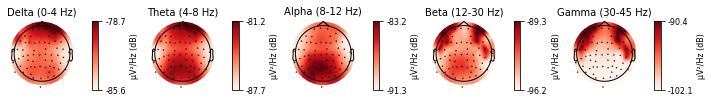

    Using multitaper spectrum estimation with 7 DPSS windows


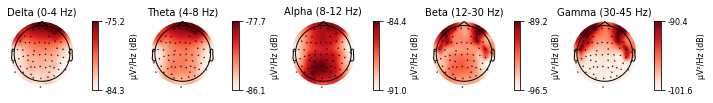

    Using multitaper spectrum estimation with 7 DPSS windows


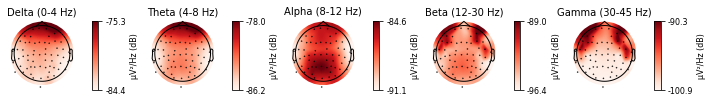

In [18]:
# Display the remaining of activities:

# here we see the average localized brain activity for the left visual stimuli
left_visual_activity = epochs['visual/left'].plot_psd_topomap()
# here we see the average localized brain activity for the left auditory stimuli
left_audio_activity = epochs['auditory/left'].plot_psd_topomap()
# here we see the average localized brain activity for the right auditory stimuli
right_audio_activity = epochs['auditory/right'].plot_psd_topomap()

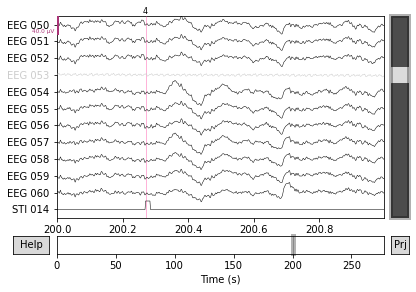

In [19]:
ecg_stimuli = raw.plot(order=chan_idxs, start=200, 
                           duration=1, events=events,
                           event_color= {
                               1: 'chocolate', 
                               2: 'darksalmon',
                               3: 'navy', 
                               4: 'hotpink', 
                               5: 'saddlebrown', 
                               32: 'gold' }
                          )

** Therefore, the brain activity as shown on the line pointed out the number 4, is visual/right brain stimuli **

In [ ]:
# You did it!!
#
# ┈┈┈┈┈┈▕▔╲
# ┈┈┈┈┈┈┈▏▕
# ┈┈┈┈┈┈┈▏▕▂▂▂
# ▂▂▂▂▂▂╱┈▕▂▂▂▏
# ▉▉▉▉▉┈┈┈▕▂▂▂▏
# ▉▉▉▉▉┈┈┈▕▂▂▂▏
# ▔▔▔▔▔▔╲▂▕▂▂|
#